# import libraries

In [275]:
import torch
import pandas as pd
import json
import re
import os
from PIL import Image
import matplotlib.pyplot as plt
from C_D_create_embeddings import embed_caption_api

# enter query

In [276]:
# query sentence

query_dict = {
    'Overall Description': "semi-formal, strapless, stretchy green velvet dress  ",
    'Specific Category': "semi-formal dress",
    'Color':"dark green",
    'Material': "velvet or velour",
    'Features': "strapless",         'Vibe': "sultry elegant",         
    'Cut': "sweetheart neckline, fitted, calve-length",         
    'Occasion': "evening wedding, holiday party, fancy date night, opera"
    } 

score_weights = {
    'Overall Description': 1,
    'Specific Category': 0.5,
    'Color': 0.9,
    'Material': 0.5,
    'Features': 0.7,
    'Vibe': 0.5,
    'Cut': 0.5,
    'Occasion': 0.4
}

# define the file paths

In [277]:
# Specify the path of images
category_folder_path = "C:/Users/Esra/Desktop/Deep_Learning/Image_Classification/Fashion/Classify_ThreadUp_Images/data/threadup/dress/"

# Specify the csv filename to store captions
captions_csv = 'thread_descriptions_dress.csv'

#for visualizing data from csv files
captions_csv_path = os.path.join(category_folder_path, captions_csv)

emb_type = "small"
# Specify the filename to store embeddings of the image captions
embeddings_json_path =  os.path.join(category_folder_path, f'embeddings_dict_batch_dress_{emb_type}.json')

# query embeddings

In [278]:
# Initialize a dictionary to store embeddings for each column
query_emb_dict = {
    'Overall Description': [],
    'Specific Category': [],
    'Color': [],
    'Material': [],
    'Features': [],
    'Vibe': [],
    'Cut': [],
    'Occasion': []
}


# Loop through each pandas column (subembed_key) and get embeddings for each entry
for subembed_key in query_emb_dict.keys():
    text = query_dict[subembed_key] # Initialize/reset the list for each column
    if text:
        query_emb_dict[subembed_key] = embed_caption_api([text], model=f"text-embedding-3-{emb_type}")
    


# calculate similarity score

In [279]:
# search for the best match between query and database embeddings

def norm_embeddings(embeds):
    norms = torch.norm(embeds, dim=1, keepdim=True)
    normalized_embeddings = embeds / norms
    return normalized_embeddings

def torchify_norm(emb_dict):
    new_dict = {}
    for col, val in emb_dict.items():
        torch_val = torch.tensor(val)
        if val:
            new_dict[col] = norm_embeddings(torch_val)
    return new_dict

query_emb_dict_torch = torchify_norm(query_emb_dict)

# To Do: load embeddings from the database
with open(embeddings_json_path, 'r') as file:
    embeddings_database_dict = json.load(file)

embeddings_dict_torch = torchify_norm(embeddings_database_dict)

In [280]:
def search_match(query_emb_dict_torch, embeddings_dict_torch, score_weights):
    N = embeddings_dict_torch["Color"].shape[0]
    weighted_sim = torch.zeros((1, N))
    for ix,  (col, val) in enumerate(query_emb_dict_torch.items()): 
        cosine_sim_matrix = torch.mm(val, embeddings_dict_torch[col].t()) # or use @
        weighted_sim +=  cosine_sim_matrix * score_weights[col]      
    return weighted_sim/ix

scores = search_match(query_emb_dict_torch, embeddings_dict_torch, score_weights)
# show the best matching 3 images

# visualize top 3 best matching images

- Overall Description: A strapless, knee-length bodycon dress in an elegant dark green velvet.
- Specific Category: Cocktail dress.
- Color: A deep, rich dark green with a luxurious sheen, consistent throughout.
- Material: Appears to be made of plush velvet with a smooth, dense pile that has a subtle luster.
- Features: Strapless with a straight-across neckline, and it appears to have a hidden closure, likely a zipper at the back.
- Vibe: Exudes a classy and sophisticated vibe, with a touch of vintage glamour due to the velvet material.
- Cut: A bodycon fit that is tailored to hug the figure closely, with a hemline that hits at knee-length.
- Occasion: Suitable for formal events, cocktail parties, or elegant evening gatherings.


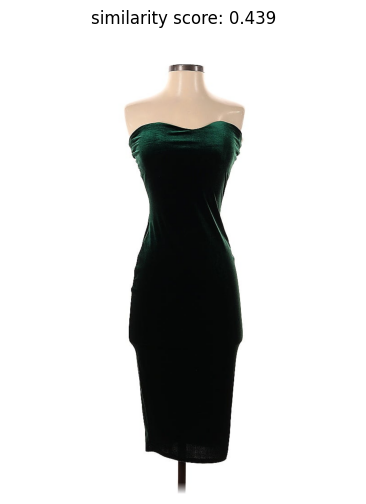

- Overall Description: A strapless, knee-length cocktail dress in a solid dark green color.
- Specific Category: Cocktail dress.
- Color: Dark green, solid color with no visible patterns.
- Material: Appears to be made of a smooth, lustrous fabric, possibly satin or a synthetic blend with a slight sheen.
- Features: Strapless design with a straight neckline, a fitted bodice, and a hidden back zipper.
- Vibe: The dress exudes a sophisticated and elegant vibe.
- Cut: Designed with a fitted silhouette through the bodice and waist, followed by a slightly flared skirt at the knee-length hem.
- Occasion: Suitable for formal events, such as evening parties, cocktail receptions, or weddings.


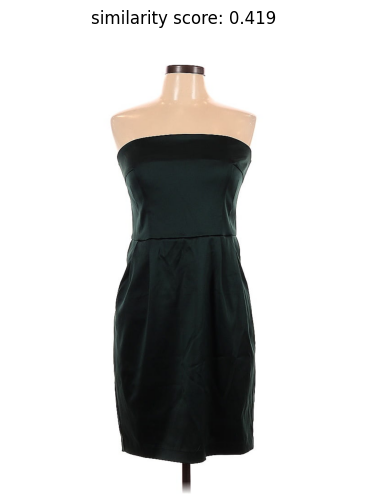

- Overall Description: A sleeveless, knee-length velvet dress in a rich emerald green color, providing an elegant and luxurious look.
- Specific Category: Cocktail dress.
- Color: The dress is a deep and intense emerald green without any patterns.
- Material: This appears to be a velvet fabric, characterized by a short, dense pile and a distinctive smooth feel.
- Features: The dress has a sweetheart neckline, wide shoulder straps, and a gathered waistline for volume in the skirt.
- Vibe: The dress exudes a classic and sophisticated vibe with a touch of vintage charm.
- Cut: The dress has a fitted bodice with a gently flared skirt, providing a flattering, semi-formal silhouette.
- Occasion: Suitable for evening events, such as cocktail parties, holiday gatherings, or dinners at upscale venues.


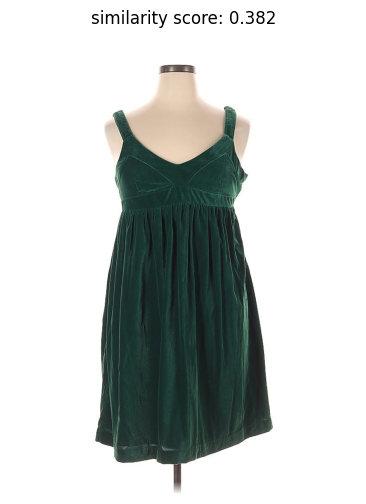

In [282]:
captions = pd.read_csv(captions_csv_path)

top_ix = scores.topk(3).indices.tolist()[0]
score_vals = scores.topk(10).values.tolist()[0]
# Iterate over the responses and display each image with its description
for ix,item in enumerate(top_ix):
    
    img_path = os.path.join(category_folder_path, captions["filename"][item])
    # Open the image
    img = Image.open(img_path)

    # Set up the matplotlib figure
    plt.figure(figsize=(6, 6))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Remove axis ticks

    # Display the description
    # plt.title(captions["description"][item] + '/n'+ score_vals[], wrap=True)
    print(captions["description"][item])
    plt.title(f'similarity score: {score_vals[ix]:.3f}', wrap=True)
   
    # Show the plot
    plt.show()